In [129]:
spark.stop()

In [81]:
core = 12
nome = "marco"
#nicolò
#marco
#francesco
#raffaele

In [82]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

#spark.catalog.clearCache()
import gc
gc.collect()

50798

In [83]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a"),
    "marco":    (4041, "user_b"),
    "francesco":(4042, "user_c"),
    "raffaele": (4043, "user_d"),
}
# recupero SparkUI e user dal mapping
SparkUI, user = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")

Hai settato 4041 e user_b: tu sei marco


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [84]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from functools import reduce
from joblib import Parallel, delayed

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType

from pyspark.sql.functions import (
    coalesce, corr, array, countDistinct, approx_count_distinct,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id, mean
)

In [85]:
os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

configs = {
   "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
   "spark.scheduler.pool": user,                                    # User pool
   "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
   "spark.executor.memory": "2200m",                                # Executor RAM
   "spark.cores.max": core,                                         # Total cores
   "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
   "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
   "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
   "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
   "spark.shuffle.service.enabled": "false",                        # No shuffle service
   "spark.ui.port": SparkUI,                                        # Custom UI port
   "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
}

spark_builder = SparkSession.builder \
   .appName("ProjectCloudVeneto") \
   .master("spark://10.67.22.135:7077")

for key, value in configs.items():
   spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

sc = spark.sparkContext

In [86]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")
print(sensors)

There are 130 sensors.

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Upload and inspect dataset

In [6]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(16, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 1:=======================================================> (38 + 1) / 39]

CPU times: user 16.5 ms, sys: 11.6 ms, total: 28.1 ms
Wall time: 25.5 s


In [8]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [9]:
# inspect dataset
df.show(3, truncate=False)

[Stage 2:=======================================================> (38 + 1) / 39]

+----------+------+------+-----+
|when      |hwid  |metric|value|
+----------+------+------+-----+
|1602058725|SW-065|S11   |0    |
|1601690338|SW-065|S126  |22   |
|1601743169|SW-065|S124  |0    |
+----------+------+------+-----+
only showing top 3 rows



In [10]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 7:=====================================================>   (60 + 4) / 64]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-115|
|SW-065|
+------+



In [7]:
#Old code to pivot only 1 hardware
'''%%time

hardware = "SW-088" 

df_hw = df.filter(col("hwid") == hardware)\
        .groupBy("when")\
        .pivot("metric")\
        .agg(first("value"))\
        .withColumn("time", from_unixtime(col("when")))\
        .orderBy("when") \
        .repartition(Npartition)

df_hw = df_hw.persist()

# show first 5 rows
engines = ["S117", "S118", "S169", "S170"]
df_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'''

'%%time\n\nhardware = "SW-088" \n\ndf_hw = df.filter(col("hwid") == hardware)        .groupBy("when")        .pivot("metric")        .agg(first("value"))        .withColumn("time", from_unixtime(col("when")))        .orderBy("when")         .repartition(Npartition)\n\ndf_hw = df_hw.persist()\n\n# show first 5 rows\nengines = ["S117", "S118", "S169", "S170"]\ndf_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'

In [ ]:
%%time

df_partitioned = df.repartition(16, col("hwid"))

# Process all hardware in parallel with window functions
df_all_hw = (df_partitioned
                   .groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

[Stage 21:==========================================>             (12 + 4) / 16]

In [10]:
df_all_hw.printSchema()

root
 |-- hwid: string (nullable = true)
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (

In [ ]:
# Get sensors list
sensors = [field.name for field in df_all_hw.schema.fields 
           if field.name not in ["when", "time", "hwid"] ]

print(sensors)

# Timestamp analysis

In [14]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [15]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [16]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 639868



5 smallest time differences:


+---------+-----+
|diff     |count|
+---------+-----+
|-15401913|1    |
|-15242152|1    |
|-15142182|1    |
|-15114523|1    |
|-15034564|1    |
+---------+-----+
only showing top 5 rows


5 largest time differences:


[Stage 109:===========================================>        (107 + 12) / 128]

+--------+-----+
|diff    |count|
+--------+-----+
|13026641|1    |
|11638832|1    |
|11360621|1    |
|10936729|1    |
|10609354|1    |
+--------+-----+
only showing top 5 rows



In [17]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    plt.show()

In [18]:
diffs = rdd_diff.collect() # check previously the dimension

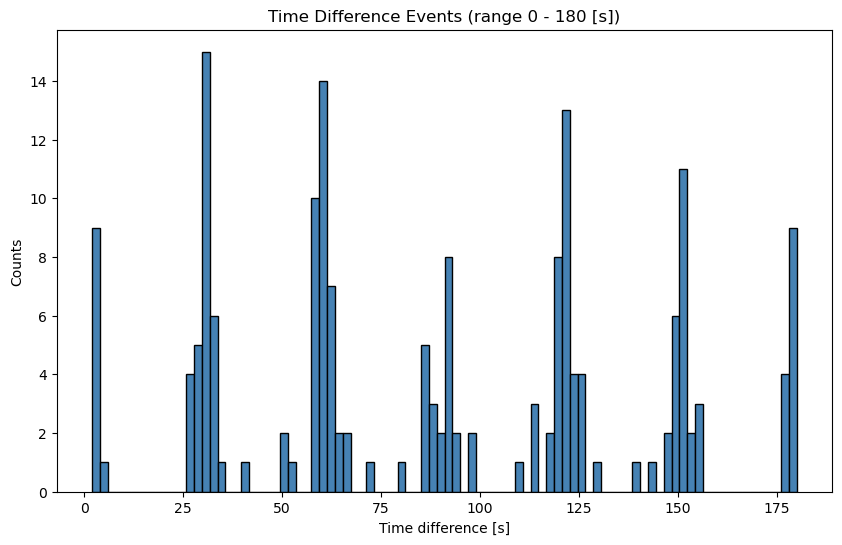

In [19]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

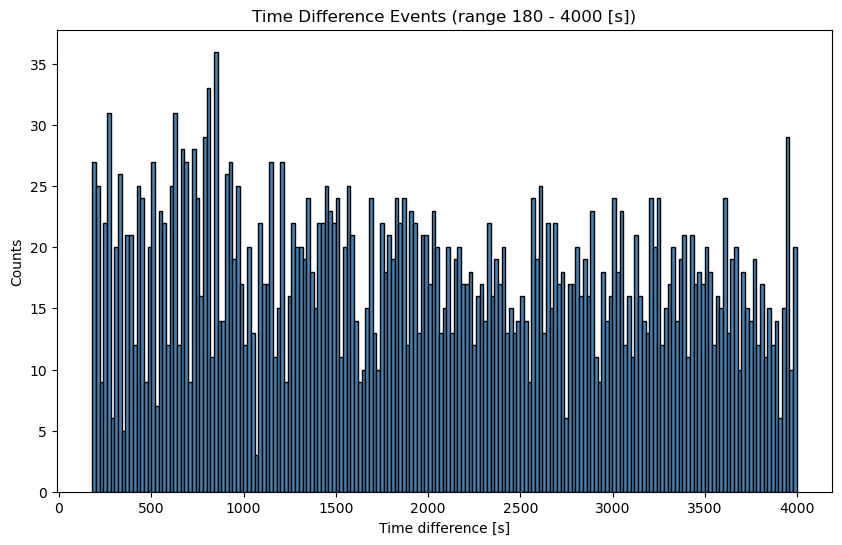

In [20]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=20)

# Data preparation

In [ ]:
def CreateGrid(df, interval):

    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        if s in ["A5", "A9"] or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_avg(col(s)).alias(s)
        aggs.append(agg_func)

    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [10]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

[Stage 981:===================================================>   (60 + 4) / 64]

+----------+-------------------+-------------------+----+----+----+----+
|when      |window_start       |window_end         |S117|S118|S169|S170|
+----------+-------------------+-------------------+----+----+----+----+
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |0   |NULL|NULL|
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |1   |0   |1   |
|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |0   |1   |0   |
+----------+-------------------+-------------------+----+----+----+----+
only showing top 3 rows

CPU times: user 246 ms, sys: 112 ms, total: 358 ms
Wall time: 35.2 s


DataFrame[hwid: string, when: int, A5: int, A9: int, ComError: int, P1: int, P10: int, P15: int, P16: int, P17: int, P18: int, P2: int, P5: int, P6: int, P7: int, P8: int, P9: int, S1: int, S10: int, S100: int, S101: int, S102: int, S106: int, S107: int, S108: int, S109: int, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: int, S123: int, S124: int, S125: int, S126: int, S127: int, S128: int, S129: int, S130: int, S137: int, S138: int, S140: int, S143: int, S147: int, S15: int, S151: int, S154: int, S157: int, S158: int, S159: int, S16: int, S163: int, S164: int, S165: int, S166: int, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: int, S179: int, S180: int, S181: int, S183: int, S19: int, S2: int, S201: int, S202: int, S203: int, S204: int, S205: int, S206: int, S25: int, S3: int, S33: int, S34: int, S35: int, S37: int, S39: int, S40: int, S41: int, S42: int, S43: int, S45: 

In [47]:
print(f"Records (rows) are {df_grid.count()}.")

# START FROM HERE TO IMPORT df_grid

In [87]:
df_grid = spark.read.parquet("/mnt/shared/df_grid.parquet/")

In [88]:
df_grid = df_grid.withColumn("A5", col("A5").cast("int"))
df_grid = df_grid.withColumn("A9", col("A9").cast("int"))

In [89]:
%%time

df_max = df_grid.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_grid.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

[Stage 4:====================================================>      (8 + 1) / 9]

CPU times: user 69.7 ms, sys: 66.4 ms, total: 136 ms
Wall time: 9.72 s


In [91]:
print(f"There are {len(useless_sensors)} useless sensors (just one value), which are:\n")
print(useless_sensors)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value), which are:

['S106', 'S108', 'S11', 'S110', 'S15', 'S16', 'S163', 'S165', 'S167', 'S17', 'S175', 'S176', 'S19', 'S34', 'S42', 'S43', 'S45', 'S49', 'S50', 'S54', 'S56', 'S57', 'S63', 'S69', 'SA12', 'SA4', 'SA8', 'SW']


There are 102 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9'

In [92]:
df_grid = df_grid.drop(*useless_sensors)

In [93]:
list_hw = df_grid.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw

['SW-106', 'SW-088', 'SW-115', 'SW-065']

In [94]:
def BuildBlocks(df, max_interval, sensors):    

    w_hw = Window.partitionBy("hwid").orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [95]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)

In [96]:
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

[Stage 12:>                                                         (0 + 1) / 1]

+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|  hwid|BlockID|      when|       window_start|         window_end|S117|S118|S169|S170|  A5|  A9|ComError|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
|SW-106|      0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00| 0.0| 1.0| 0.0| 1.0|NULL|NULL|    NULL|
|SW-106|      0|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00| 0.0| 1.0| 0.0| 1.0|NULL|NULL|    NULL|
|SW-106|      0|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00| 0.0| 1.0| 0.0| 1.0|NULL|NULL|    NULL|
+------+-------+----------+-------------------+-------------------+----+----+----+----+----+----+--------+
only showing top 3 rows



In [99]:
for hw in list_hw:
    print(f"{hw} has {df_blocks.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

SW-106 has 186 Blocks.


SW-088 has 1047 Blocks.
SW-115 has 78 Blocks.
SW-065 has 101 Blocks.


--------------------------SW-106------------------------------
Longest blocks:

     BlockID  minutes
183      180     3510
184      175     3963
185      182     4658


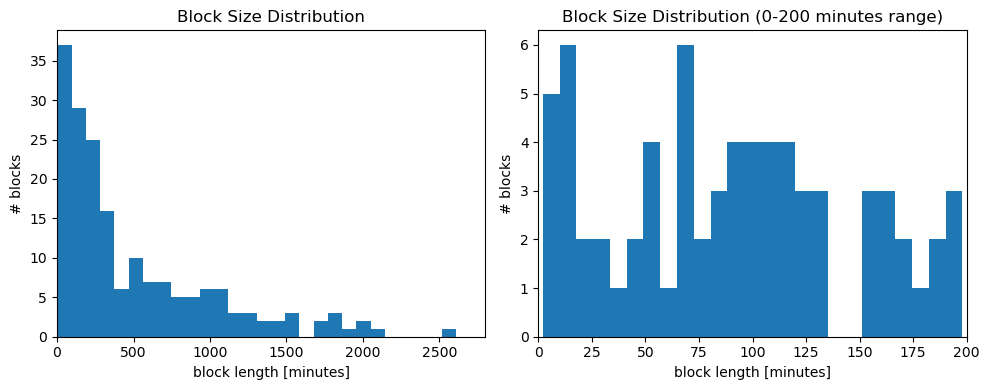

--------------------------SW-088------------------------------
Longest blocks:

      BlockID  minutes
1044      460     2095
1045      483     2135
1046      164     2374


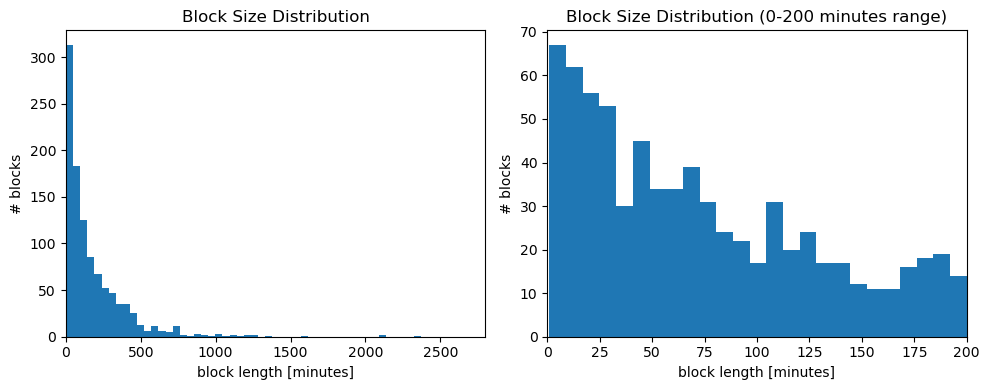

--------------------------SW-115------------------------------
Longest blocks:

    BlockID  minutes
75       73     8623
76       23    10977
77        8    14200


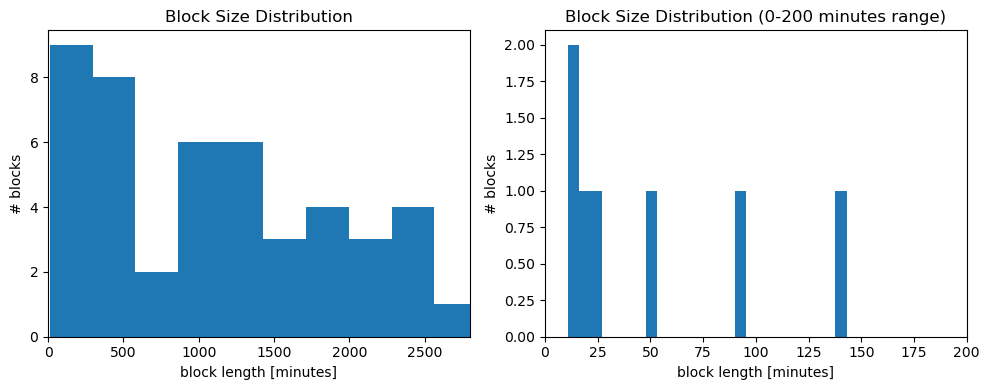

--------------------------SW-065------------------------------


Longest blocks:

     BlockID  minutes
98        40     5123
99        12     6205
100       15    12744


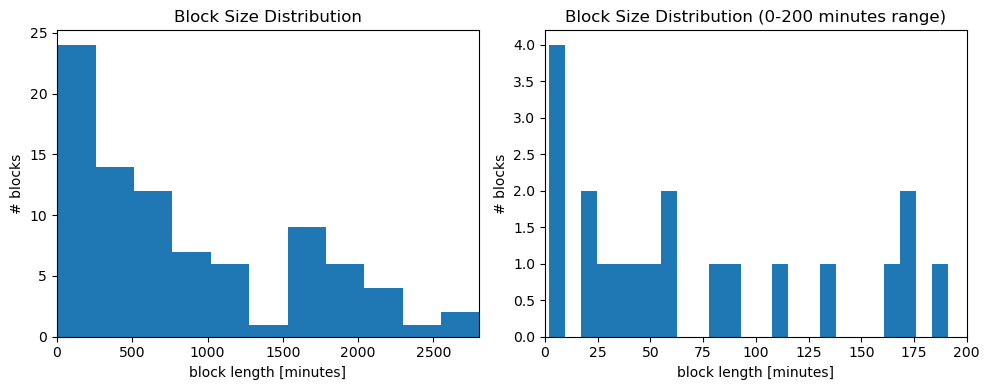

In [100]:
for hw in list_hw:


    print(f"--------------------------{hw}------------------------------")
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("minutes")).orderBy("minutes")
    data = dist_blocks.toPandas()
    print("Longest blocks:\n")
    print( data.tail(3) )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['minutes'], bins=50)
    axes[0].set_xlim(0, 2800)
    axes[0].set_xlabel("block length [minutes]")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")
    
    data_low_range = data[(data['minutes'] >= 0) & (data['minutes'] <= 200)]
    axes[1].hist(data_low_range['minutes'], bins=25)
    axes[1].set_xlim(0, 200)
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Size Distribution (0-200 minutes range)")
    plt.tight_layout()
    plt.show()

# Anomaly detection (1)

## Distributed Analysis for Anomaly Detection

In [106]:
def detect_anomalies(df, time_separator, threshold, sensors):
    '''
    Crea colonne con flag per anomalie.
    '''
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('when')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Quando ci sono delle righe comprese tra anomalie con stesso ID, queste righe sono a loro volta considerate anomalie
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [107]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*40, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

list_df_anomalies

CPU times: user 133 ms, sys: 115 ms, total: 247 ms
Wall time: 6.66 s


{'SW-106': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-088': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-115': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-065': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int]}

In [108]:
hw_to_inspect = 'SW-088'

In [109]:
%%time

list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|71     |1602481950|1.0 |0.0 |1.0 |1.0 |true     |false    |false    |false    |1           |
|71     |1602482010|1.0 |0.0 |0.0 |1.0 |true     |false    |false    |false    |1           |
|71     |1602482070|0.0 |0.0 |0.0 |1.0 |true     |false    |false    |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 6.22 ms, sys: 454 μs, total: 6.67 ms
Wall time: 3.65 s


In [110]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
BlockWithAnom.show(3, truncate=False)

Know some BlockID where there are anomalies, so we can plot it and see.
+-------+
|BlockID|
+-------+
|71     |
|90     |
|139    |
+-------+
only showing top 3 rows



In [116]:
def inspect_anomalies_old(df, sensor, blockID):

    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    t = range(len(anomalies))

    plt.bar(t, values, width = 1, alpha = 0.5, edgecolor=None, lw=1)
    plt.bar(t, anomalies, width= 1, alpha = 0.5, label="anomal")
    plt.xlabel("Minutes")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.legend()
    plt.show()

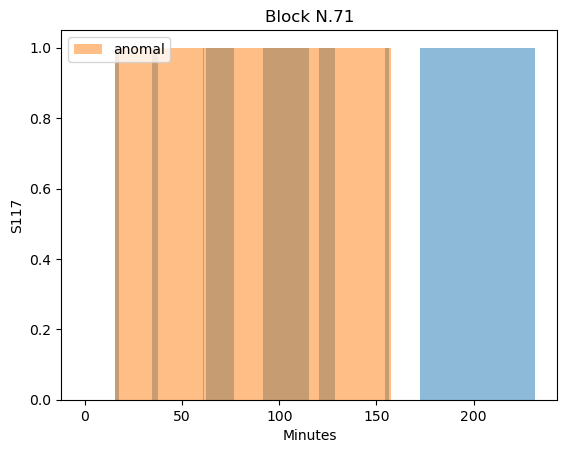

In [117]:
inspect_anomalies_old(list_df_anomalies[hw_to_inspect], 'S117', BlockWithAnom.first()[0])

In [118]:
def inspect_anomalies(df, sensor, blockID):
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    whens     = extract_when(df)

    if not whens:
        print(f"Nessun dato per BlockID={blockID}")
        return

    # Costruisci asse temporale continuo (secondi, passo 60)
    t_min = min(whens)
    t_max = max(whens)
    full_t = list(range(t_min, t_max + 60, 60))  

    # Normalizza asse x a partire da 0 (in minuti)
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]

    # Mappa tempi -> valori/anomalie
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))

    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]

    # Missing: dove non c’è un dato registrato
    missing = [1 if t not in whens_rel else 0 for t in full_t_rel]

    # Plot con colori espliciti
    plt.bar(full_t_rel, aligned_values, width=1, alpha=0.5, color="blue",   label=sensor)
    plt.bar(full_t_rel, aligned_anomalies, width=1, alpha=0.5, color="orange", label="anomal")
    plt.bar(full_t_rel, missing, width=1, alpha=0.5, color="red",   label="missing")

    plt.xlabel("Minutes (relative to block start)")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.show()

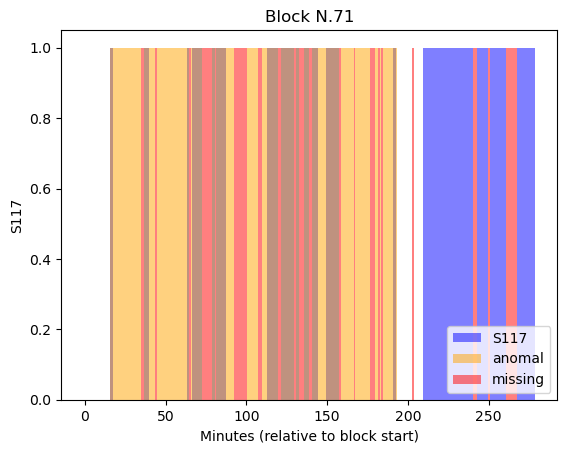

In [119]:
inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', BlockWithAnom.first()[0])

In [128]:
df_blocks.where( (col("BlockID")==71) & (col("hwid")==hw_to_inspect)) \
    .select("window_start","window_end","NextDiff",'S117') \
    .withColumn("NumeroRiga", monotonically_increasing_id()).show(250)

+-------------------+-------------------+----------+----+----------+
|       window_start|         window_end|NextDiff_s|S117|NumeroRiga|
+-------------------+-------------------+----------+----+----------+
|2020-10-12 05:36:00|2020-10-12 05:37:00|        60| 0.0|         0|
|2020-10-12 05:37:00|2020-10-12 05:38:00|        60| 0.0|         1|
|2020-10-12 05:38:00|2020-10-12 05:39:00|        60| 0.0|         2|
|2020-10-12 05:39:00|2020-10-12 05:40:00|        60| 0.0|         3|
|2020-10-12 05:40:00|2020-10-12 05:41:00|        60| 0.0|         4|
|2020-10-12 05:41:00|2020-10-12 05:42:00|        60| 0.0|         5|
|2020-10-12 05:42:00|2020-10-12 05:43:00|        60| 0.0|         6|
|2020-10-12 05:43:00|2020-10-12 05:44:00|        60| 0.0|         7|
|2020-10-12 05:44:00|2020-10-12 05:45:00|        60| 0.0|         8|
|2020-10-12 05:45:00|2020-10-12 05:46:00|        60| 0.0|         9|
|2020-10-12 05:46:00|2020-10-12 05:47:00|        60| 0.0|        10|
|2020-10-12 05:47:00|2020-10-12 05

In [120]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    # df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )
    #df_blocks_anom = df_blocks_anom.persist()

list_df_blocks_anom[hw_to_inspect].printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- window_start: timestamp_ntz (nullable = true)
 |-- window_end: timestamp_ntz (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: double (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P15: double (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: double (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: double (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S109: double (nullable = true)
 |-- S112: double (nullable = true)
 |-- S113: double

## Linear correlation setup (used for anomalies, S125-S181, A5-A9)

In [27]:
def correlations(df, sensors_list, target_col, batch_size=25):
    """
    Compute correlations between sensors and target column in batches.
    Returns sorted DataFrame by absolute correlation (descending).
    """   
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [28]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    import matplotlib.pyplot as plt
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{hw} - {feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

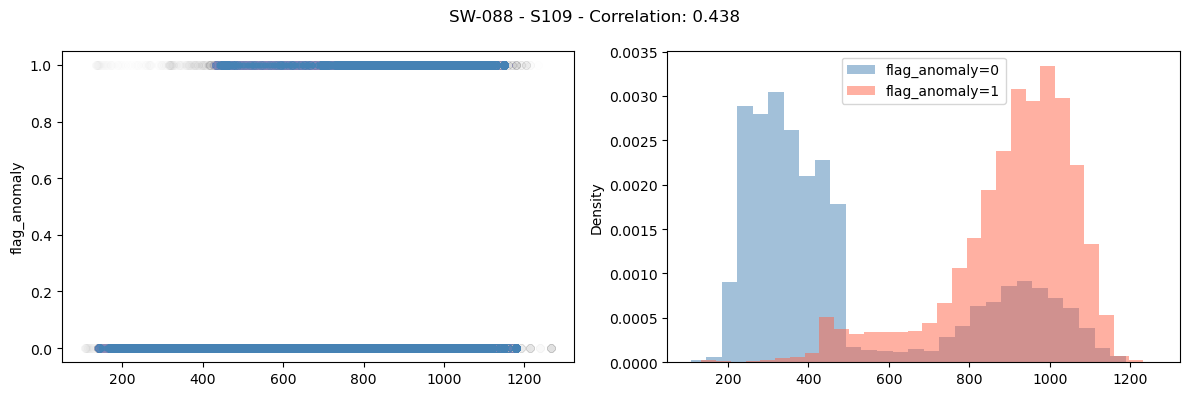

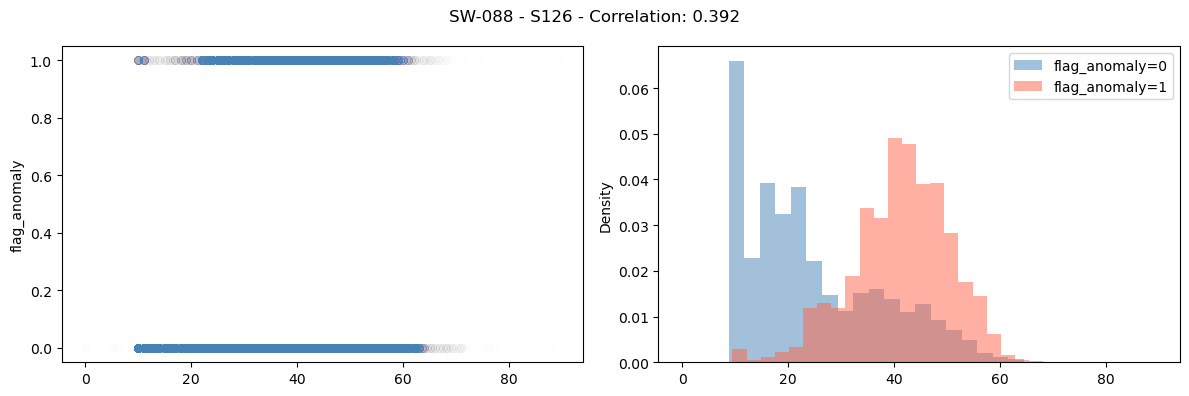

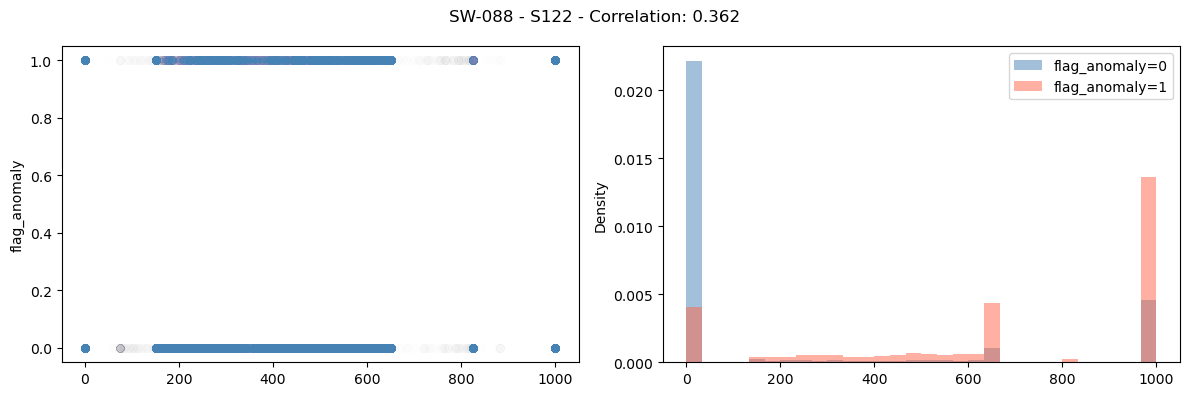

CPU times: user 1.24 s, sys: 55.2 ms, total: 1.29 s
Wall time: 32.5 s


25/08/20 16:50:24 ERROR TaskSchedulerImpl: Lost executor 3 on 10.67.22.135: Command exited with code 137


In [29]:
%%time

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    anomaly_corr = correlations(list_df_blocks_anom[hw], useful_sensors[hw], 'flag_anomaly')
    
    # top_anom_corr = anomaly_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()

    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)
    
    # print(top_anom_corr)
    

## Alternative approach: Random Forest 

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2504):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy


In [44]:
sensors_forest = sensors
model, preds = {}, {}
for hw in [hw_to_inspect]: # substitute hw_to_inspect with list_hw
    # ATTENZIONE: NON VA PERCHÈ CI SONO DEI NULL NEL DF
    model[hw], preds[hw] = run_random_forest(list_df_blocks_anom[hw], feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 20, max_depth = 15, test_fraction=0.5)

Training on 95504 rows, testing on 96483 rows


25/08/20 17:30:16 WARN TaskSetManager: Lost task 0.0 in stage 2991.0 (TID 2142) (10.67.22.135 executor 6): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$1331/0x00007fe0cc98b400`: (struct<P1:double,P10:double,P15:double,P16:double,P17:double,P18:double,P2:double,P5:double,P6:double,P7:double,P8:double,P9:double,S1:double,S10:double,S100:double,S101:double,S102:double,S106:double,S107:double,S108:double,S109:double,S11:double,S110:double,S112:double,S113:double,S114:double,S115:double,S117:double,S118:double,S122:double,S123:double,S124:double,S125:double,S126:double,S127:double,S128:double,S129:double,S130:double,S137:double,S138:double,S140:double,S143:double,S147:double,S15:double,S151:double,S154:double,S157:double,S158:double,S159:double,S16:double,S163:double,S164:double,S165:double,S166:double,S167:double,S169:double,S17:double,S170:double,S171:double,S172:double,S173:double,S174:double,S175:double,S176:doub

Py4JJavaError: An error occurred while calling o9960.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2991.0 failed 4 times, most recent failure: Lost task 0.3 in stage 2991.0 (TID 2148) (10.67.22.135 executor 6): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$1331/0x00007fe0cc98b400`: (struct<P1:double,P10:double,P15:double,P16:double,P17:double,P18:double,P2:double,P5:double,P6:double,P7:double,P8:double,P9:double,S1:double,S10:double,S100:double,S101:double,S102:double,S106:double,S107:double,S108:double,S109:double,S11:double,S110:double,S112:double,S113:double,S114:double,S115:double,S117:double,S118:double,S122:double,S123:double,S124:double,S125:double,S126:double,S127:double,S128:double,S129:double,S130:double,S137:double,S138:double,S140:double,S143:double,S147:double,S15:double,S151:double,S154:double,S157:double,S158:double,S159:double,S16:double,S163:double,S164:double,S165:double,S166:double,S167:double,S169:double,S17:double,S170:double,S171:double,S172:double,S173:double,S174:double,S175:double,S176:double,S178:double,S179:double,S180:double,S181:double,S183:double,S19:double,S2:double,S201:double,S202:double,S203:double,S204:double,S205:double,S206:double,S25:double,S3:double,S33:double,S34:double,S35:double,S37:double,S39:double,S40:double,S41:double,S42:double,S43:double,S45:double,S46:double,S47:double,S49:double,S5:double,S50:double,S53:double,S54:double,S55:double,S56:double,S57:double,S6:double,S63:double,S64:double,S69:double,S7:double,S70:double,S71:double,S72:double,S73:double,S8:double,S80:double,S81:double,S83:double,S86:double,S9:double,S90:double,S94:double,S97:double,SA1:double,SA10:double,SA11:double,SA12:double,SA2:double,SA3:double,SA4:double,SA5:double,SA6:double,SA7:double,SA8:double,SA9:double,SW_double_VectorAssembler_1a19792eb7fc:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage53.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1226)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2487)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1228)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1221)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:274)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:168)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$1331/0x00007fe0cc98b400`: (struct<P1:double,P10:double,P15:double,P16:double,P17:double,P18:double,P2:double,P5:double,P6:double,P7:double,P8:double,P9:double,S1:double,S10:double,S100:double,S101:double,S102:double,S106:double,S107:double,S108:double,S109:double,S11:double,S110:double,S112:double,S113:double,S114:double,S115:double,S117:double,S118:double,S122:double,S123:double,S124:double,S125:double,S126:double,S127:double,S128:double,S129:double,S130:double,S137:double,S138:double,S140:double,S143:double,S147:double,S15:double,S151:double,S154:double,S157:double,S158:double,S159:double,S16:double,S163:double,S164:double,S165:double,S166:double,S167:double,S169:double,S17:double,S170:double,S171:double,S172:double,S173:double,S174:double,S175:double,S176:double,S178:double,S179:double,S180:double,S181:double,S183:double,S19:double,S2:double,S201:double,S202:double,S203:double,S204:double,S205:double,S206:double,S25:double,S3:double,S33:double,S34:double,S35:double,S37:double,S39:double,S40:double,S41:double,S42:double,S43:double,S45:double,S46:double,S47:double,S49:double,S5:double,S50:double,S53:double,S54:double,S55:double,S56:double,S57:double,S6:double,S63:double,S64:double,S69:double,S7:double,S70:double,S71:double,S72:double,S73:double,S8:double,S80:double,S81:double,S83:double,S86:double,S9:double,S90:double,S94:double,S97:double,SA1:double,SA10:double,SA11:double,SA12:double,SA2:double,SA3:double,SA4:double,SA5:double,SA6:double,SA7:double,SA8:double,SA9:double,SW_double_VectorAssembler_1a19792eb7fc:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.ScalaUDF_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificUnsafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage53.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1226)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2487)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 32 more


In [91]:
preds[hw_to_inspect].select('flag_anomaly', 'prediction', 'probability').show(100, truncate=0)

+------------+----------+------------------------------------------+
|flag_anomaly|prediction|probability                               |
+------------+----------+------------------------------------------+
|0           |0.0       |[0.9999304750869061,6.952491309385863E-5] |
|0           |0.0       |[0.98,0.02]                               |
|0           |0.0       |[0.9989611103922746,0.0010388896077253701]|
|0           |0.0       |[0.9999715284234444,2.847157655565905E-5] |
|0           |0.0       |[0.9999020035103504,9.799648964951766E-5] |
|0           |0.0       |[0.9925238959467635,0.00747610405323654]  |
|0           |0.0       |[0.9999956072918954,4.392708104546453E-6] |
|0           |0.0       |[0.9998742777822297,1.257222177703504E-4] |
|0           |0.0       |[0.9999874319229158,1.2568077084206116E-5]|
|0           |0.0       |[0.9999874319229158,1.2568077084206116E-5]|
|0           |0.0       |[0.999975921131549,2.4078868451112594E-5] |
|0           |0.0       |[0.999995

## Alternative approach: PCA

In [40]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

def covariance_matrix(df, cols=None):
    """
    This function returns the covariance matrix from the df
    """
    
    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    means = df.select([mean(c).alias(c) for c in cols]).collect()[0].asDict()
    
    df_centered = df.select(*[(col(c) - means[c]).alias(c) for c in cols])
    
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_centered_vec = assembler.transform(df_centered).select("features")
    
    n = df.count()
    cov_matrix = (
        df_centered_vec.rdd
        .map(lambda row: row.features.toArray())
        .map(lambda x: np.outer(x, x))
        .reduce(lambda a, b: a + b) / (n - 1)
    )
    
    return cov_matrix, cols

In [41]:
pca_sensors = [ 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10','S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
for hw in [hw_to_inspect]: # mettici list_hw per averlo generale   
    df_anomalies_n = list_df_blocks_anom[hw].select(pca_sensors)
    df_anomalies_n = df_anomalies_n.na.drop()

    cov_matrix, columns = covariance_matrix(df_anomalies_n)

    print("Columns:", columns)
    print("Covariance matrix:\n", cov_matrix)    
    #df_anomalies_n.printSchema()
    #df_anomalies_n.show(5)

[Stage 1962:==========================================>             (3 + 1) / 4]

Columns: ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
Covariance matrix:
 [[1.10804046e-01 6.21838345e-01 0.00000000e+00 ... 3.843

# Anomaly Detection (2)

## Correlation between device load and external temperature (S125-S181 vs S41) (Attualmente not working)

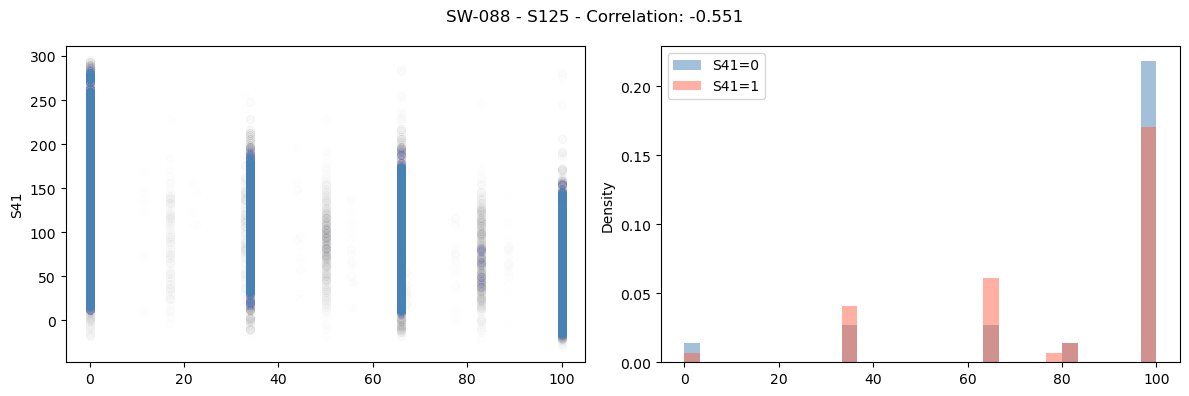

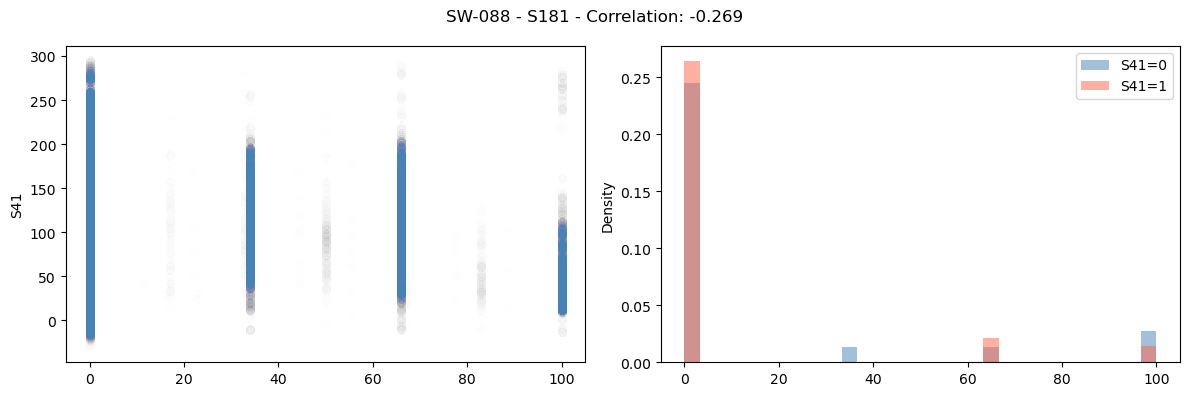

CPU times: user 725 ms, sys: 0 ns, total: 725 ms
Wall time: 5.27 s


In [33]:
%%time

load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    temper_corr = correlations(list_df_blocks_anom[hw], load_sensors, temperature_sensor)

    plot_correlations(list_df_blocks_anom[hw], temperature_sensor, load_sensors, temper_corr, hw)
    
    # print(top_anom_corr)

In [36]:
list_df_blocks_anom[hw_to_inspect].select('S41').show(10)

# Well well this is a problem, non è binario

+-----+
|  S41|
+-----+
|177.0|
|176.0|
|179.0|
|179.0|
|179.0|
|180.0|
|176.0|
|176.0|
|178.0|
|177.0|
+-----+
only showing top 10 rows



# Predictive maintenance

## Conversion of Alarms (A5, A9)

In [32]:
def extract_alarms(df, columns=["A5", "A9"], bits=[6, 7, 8]):
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )
    
    all_bit_cols = [col(f"{bit}-{col_name}") for col_name in columns for bit in bits]
    
    # condition ad least one alarm to get overheating
    condition = sum(all_bit_cols) > 0 # already menaged NULL, it gives 0
    df = df.withColumn("overheating", when(condition, 1).otherwise(0).cast("int"))
 
    return df

In [33]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms(df_grid.filter( col("hwid") == hw).select("when","A5","A9"),
                            columns=["A5", "A9"],
                            bits=[6, 7, 8] )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum("overheating")).collect()[0][0]} overheating signals." )

#list_df_alarms['SW-088'].show(3)
#list_df_alarms['SW-088'].where( (col("A5").isNotNull()) | (col("A9").isNotNull()) ).show(3)
list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(3)

For hardware SW-088 were recorded 66 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
For hardware SW-115 were recorded 0 overheating signals.
For hardware SW-065 were recorded 0 overheating signals.
+----------+-----+---+----+----+----+----+----+----+-----------+
|      when|   A5| A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+---+----+----+----+----+----+----+-----------+
|1601510790|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601597190|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601686290|18496|  0|   0|   1|   0|   0|   0|   0|          1|
+----------+-----+---+----+----+----+----+----+----+-----------+
only showing top 3 rows



In [34]:
%%time

list_df_final = {}

print("Check previous n° of alarms with respect to total lines.\n")

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    #list_df_final[hw] = df_final.persist()
    list_df_final[hw] = df_final
    print( f"For hardware {hw} there are {list_df_final[hw].count()} lines" )

Check previous n° of alarms with respect to total lines.

For hardware SW-088 there are 191987 lines
For hardware SW-106 there are 105885 lines


For hardware SW-115 there are 237674 lines
For hardware SW-065 there are 136284 lines
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 9.66 s


## Correlation analysis for alarms

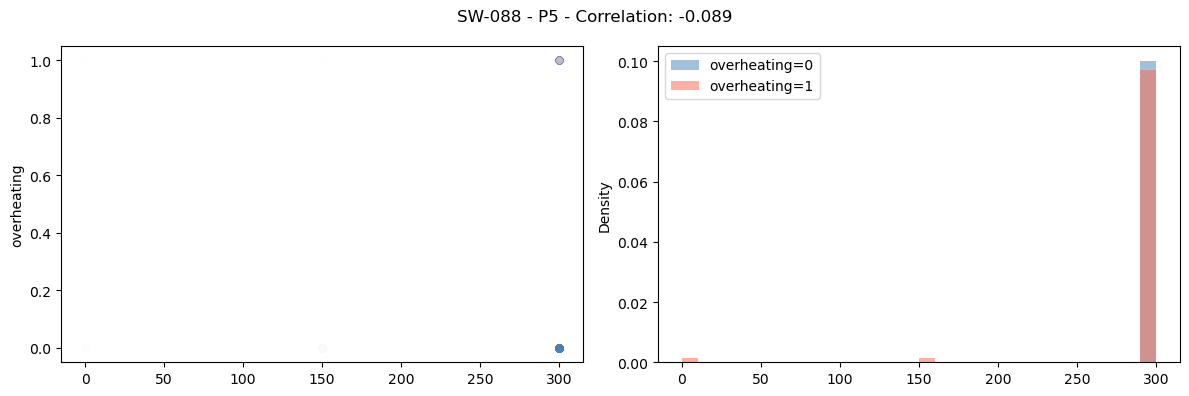

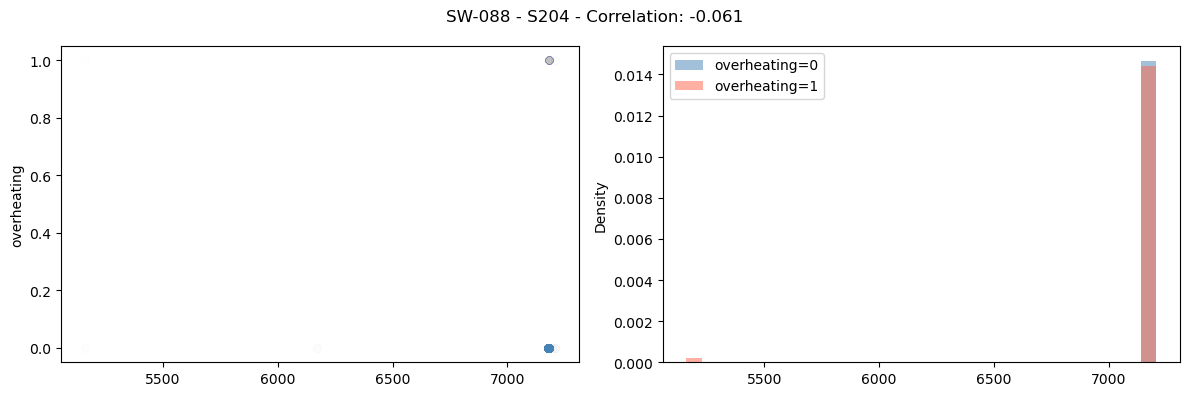

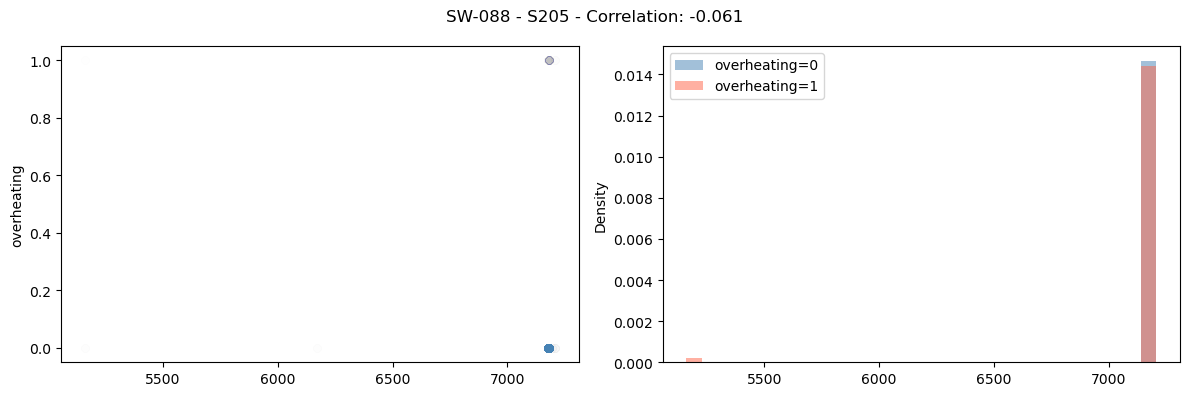

CPU times: user 1.13 s, sys: 39.2 ms, total: 1.17 s
Wall time: 22.1 s


In [36]:
%%time

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    alarm_corr = correlations(list_df_final[hw], useful_sensors[hw], 'overheating')
    
    # top_alarm_corr = alarm_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()

    plot_correlations(list_df_final[hw], 'overheating', top_alarm_corr, alarm_corr, hw)
    
    # print(top_anom_corr)

## Predictive modeling 

### Before Oveheating (predictive flag)

In [85]:
print("prima mi preparo una colonna flag che mi dice quali dati sono stati presi al max 30 min prima dell'overheating")

prima mi preparo una colonna flag che mi dice quali dati sono stati presi al max 30 min prima dell'overheating


In [86]:
list_hw

['SW-088', 'SW-106', 'SW-115', 'SW-065']

In [88]:
df_final088 = list_df_final['SW-088']

In [156]:
def add_predictive(df, window_before_heating=30, debug=False): #window_before_heating in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    # 1. individua inizio sequenza
    df = df.withColumn("prev_overheating", lag("overheating").over(w))
    df = df.withColumn(
        "is_start",
        when(
            (col("overheating") == 1) &
            ((col("prev_overheating") != 1) | col("prev_overheating").isNull()),
            1
        ).otherwise(0)
    )

    # 2. timestamp inizio sequenza (solo sugli start)
    df = df.withColumn("start_time", when(col("is_start") == 1, col("when")))

    # 3. propaga verso il futuro: "il prossimo start_time"
    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df = df.withColumn(
        "next_start_time",
        first("start_time", ignorenulls=True).over(w_future)
    )

    # 4. calcola predictive: nei 30 minuti prima del prossimo inizio sequenza
    window_seconds = window_before_heating * 60
    df = df.withColumn(
        "predictive",
        when(
            (col("next_start_time").isNotNull()) &
            (col("overheating") == 0) &
            ((col("next_start_time") - col("when")) > 0) &
            ((col("next_start_time") - col("when")) <= window_seconds),
            1
        ).otherwise(0)
    )

    if debug:
        return df.select("BlockID","when","window_start","overheating","prev_overheating",
                         "is_start","start_time","next_start_time","predictive")
    else:
        return df.select("BlockID","when","overheating","predictive")

In [157]:
df_predictive = add_predictive(df_final088.select("when","window_start","BlockID","overheating"), window_before_heating=30, debug = True )

In [158]:
df_predictive.where( col("overheating") == 1 ).orderBy(col("when").asc()).show(50)

[Stage 2725:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|      0|1601510790|2020-10-01 00:06:00|          1|               0|       1|1601510790|     1601510790|         0|
|      5|1601597190|2020-10-02 00:06:00|          1|               0|       1|1601597190|     1601597190|         0|
|      8|1601686290|2020-10-03 00:51:00|          1|               0|       1|1601686290|     1601686290|         0|
|     13|1601769750|2020-10-04 00:02:00|          1|               0|       1|1601769750|     1601769750|         0|
|     20|1601856330|2020-10-05 00:05:00|          1|               0|       1|1601856330|     1601856330|         0|
|     26|1601942610|2020-10-06 00:03:00|          1|            

In [159]:
df_predictive.where( col("BlockID") == 723 ).orderBy( col("when").desc() ).show(5)

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    723|1612537230|2021-02-05 15:00:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537170|2021-02-05 14:59:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537050|2021-02-05 14:57:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612536990|2021-02-05 14:56:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612536930|2021-02-05 14:55:00|          0|               0|       0|      NULL|           NULL|         0|
+-------+----------+-------------------+-----------+------------

In [160]:
df_predictive.where( (col("when") >= 1612537050) & (col("when") <= 1612540710) ).orderBy(col("when").asc()).show(50)

[Stage 2807:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    723|1612537050|2021-02-05 14:57:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537170|2021-02-05 14:59:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537230|2021-02-05 15:00:00|          0|               0|       0|      NULL|           NULL|         0|
|    724|1612539450|2021-02-05 15:37:00|          0|            NULL|       0|      NULL|     1612540530|         1|
|    724|1612539510|2021-02-05 15:38:00|          0|               0|       0|      NULL|     1612540530|         1|
|    724|1612539570|2021-02-05 15:39:00|          0|            

In [161]:
df_predictive.where( (col("when") >= 1612049850) & (col("when") <= 1612051890) ).orderBy(col("when").asc()).show(60)

[Stage 2848:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    681|1612049850|2021-01-30 23:37:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612049910|2021-01-30 23:38:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612049970|2021-01-30 23:39:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612050030|2021-01-30 23:40:00|          0|               0|       0|      NULL|     1612051830|         1|
|    681|1612050090|2021-01-30 23:41:00|          0|               0|       0|      NULL|     1612051830|         1|
|    681|1612050150|2021-01-30 23:42:00|          0|            

In [162]:
# join predictive column

df_final088 = df_final088.join( df_predictive.select('when', 'predictive') , on='when', how='left' )
df_final088.printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- window_start: timestamp_ntz (nullable = true)
 |-- window_end: timestamp_ntz (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: double (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P15: double (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: double (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: double (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S106: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S108: double (nullable = true)
 |-- S109: double

## SVM / RegressioneLogistica (su alarm)

In [163]:
top_corr_alarm = ["S53","S7","S172","S173","S39","S40"]

In [166]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="predictive")
lr_model = lr.fit(train_data)

# 5. Display model coefficients
print("=== MODEL COEFFICIENTS ===")
print(f"Intercept: {lr_model.intercept:.4f}")
for feature, coeff in zip(top_corr_alarm, lr_model.coefficients):
    direction = "increases" if coeff > 0 else "decreases"
    print(f"{feature}: {coeff:.4f} - {direction} P(predictive=1)")

# 6. Make predictions
predictions = lr_model.transform(test_data)

# 7. Extract probability of predictive=1
get_prob_1 = udf(lambda prob: float(prob[1]), DoubleType())
predictions_with_prob = predictions.withColumn("prob_predictive_1", get_prob_1(col("probability")))

print("\n=== SAMPLE PREDICTIONS ===")
predictions_with_prob.select("predictive", "prob_predictive_1").show(10)

# 8. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)
summary = lr_model.summary

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {summary.accuracy:.4f}")

# 9. Manual probability calculation function
def calculate_probability(feature_values):
    """Calculate P(predictive=1) = 1 / (1 + exp(-(intercept + sum(coeff_i * x_i))))"""
    linear_combination = lr_model.intercept + sum(coeff * val for coeff, val in zip(lr_model.coefficients, feature_values))
    return 1 / (1 + np.exp(-linear_combination))

# Example usage
example_values = [0.0, 1.0, 0.5, 0.2, 1.1, 0.8]  # Replace with actual sensor values
manual_prob = calculate_probability(example_values)
print(f"\nManual calculation example: {manual_prob:.4f}")

Original rows: 191987, Clean rows: 185879


25/08/19 21:30:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

=== MODEL COEFFICIENTS ===
Intercept: -15.3732
S53: -2.4931 - decreases P(predictive=1)
S7: 8.9245 - increases P(predictive=1)
S172: 4.9154 - increases P(predictive=1)
S173: 3.3085 - increases P(predictive=1)
S39: 0.0057 - increases P(predictive=1)
S40: -0.0059 - decreases P(predictive=1)

=== SAMPLE PREDICTIONS ===


+----------+--------------------+
|predictive|   prob_predictive_1|
+----------+--------------------+
|         0|0.017112218708874583|
|         0|0.017008628111901403|
|         0| 0.01710435224478024|
|         0|0.017124025070843762|
|         0|0.017020364240471597|
|         0|0.017012539270886196|
|         0|0.017131900424966817|
|         0| 0.01703602479149824|
|         0|0.017124025070843762|
|         0| 0.01702819274682843|
+----------+--------------------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7859


[Stage 3894:============================================>           (4 + 1) / 5]

Accuracy: 0.9928

Manual calculation example: 0.0346


Original rows: 191987, Clean rows: 185879


=== SVM HYPERPLANE ===
Intercept: -2.1363
Coefficients (hyperplane): [0.5016083527204447,0.5187872820349008,0.11583300041665565,-0.11229206641327225,-0.000427472703329341,0.0004234862393562192]

=== COEFFICIENT INTERPRETATION ===
S53: 0.5016 - pushes towards predictive=1
S7: 0.5188 - pushes towards predictive=1
S172: 0.1158 - pushes towards predictive=1
S173: -0.1123 - pushes towards predictive=0
S39: -0.0004 - pushes towards predictive=0
S40: 0.0004 - pushes towards predictive=1

=== SAMPLE PREDICTIONS ===


+----------+----------+
|predictive|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7597
Accuracy: 0.9932
Correct predictions: 36877/37128

=== COMBINATION COLUMN ADDED ===


+----------+-------------------+---+---+----+----+-----+-----+
|predictive|        combination|S53| S7|S172|S173|  S39|  S40|
+----------+-------------------+---+---+----+----+-----+-----+
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1|-1.0000059141882096|1.0|1.0| 1.0| 0.0|102.0|103.0|
|         1| -1.000856873130895|1.0|1.0| 1.0| 0.0|103.0|102.0|
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
+----------+-------------------+---+---+----+----+-----+-----+
only showing top 5 rows




=== PLOTTING DATA ===
Data shape: (185879, 8)
Combination stats:
  Min: -2.2696
  Max: -0.9901
  Mean: -1.6098


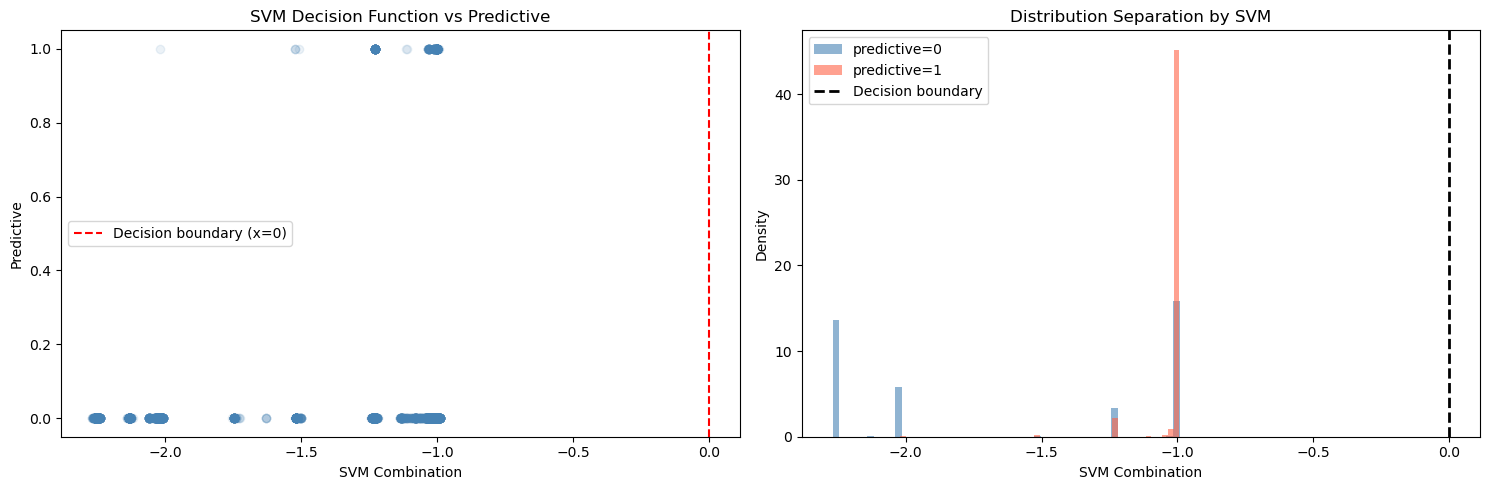


=== SEPARATION QUALITY ===
Class 0 (predictive=0): mean=-1.6140, std=0.5771
Class 1 (predictive=1): mean=-1.0146, std=0.0614
Mean difference: 0.5994
Decision boundary accuracy: 0.9929 (184557/185879)


In [168]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train SVM model
svc = LinearSVC(featuresCol="features", labelCol="predictive")
svc_model = svc.fit(train_data)

# 5. Display model coefficients (hyperplane)
print("=== SVM HYPERPLANE ===")
print(f"Intercept: {svc_model.intercept:.4f}")
print("Coefficients (hyperplane):", svc_model.coefficients)

print("\n=== COEFFICIENT INTERPRETATION ===")
for feature, coeff in zip(top_corr_alarm, svc_model.coefficients):
    direction = "pushes towards predictive=1" if coeff > 0 else "pushes towards predictive=0"
    print(f"{feature}: {coeff:.4f} - {direction}")

# 6. Make predictions
predictions = svc_model.transform(test_data)

print("\n=== SAMPLE PREDICTIONS ===")
predictions.select("predictive", "prediction").show(10)

# 7. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)

# Count correct predictions
total_predictions = predictions.count()
correct_predictions = predictions.filter(col("predictive") == col("prediction")).count()
accuracy = correct_predictions / total_predictions

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Correct predictions: {correct_predictions}/{total_predictions}")

# 8. Add combination column using SVM coefficients
from pyspark.sql.functions import lit

# Calculate linear combination: intercept + sum(coeff_i * x_i)
combination_expr = lit(svc_model.intercept)
for i, (feature, coeff) in enumerate(zip(top_corr_alarm, svc_model.coefficients)):
    combination_expr = combination_expr + (col(feature) * lit(float(coeff)))

df_with_combination = df_clean.withColumn("combination", combination_expr)

print(f"\n=== COMBINATION COLUMN ADDED ===")
df_with_combination.select("predictive", "combination", *top_corr_alarm).show(5)

# 9. Convert to Pandas for plotting
import matplotlib.pyplot as plt

pd_df = df_with_combination.select("predictive", "combination", *top_corr_alarm).toPandas()

print(f"\n=== PLOTTING DATA ===")
print(f"Data shape: {pd_df.shape}")
print(f"Combination stats:")
print(f"  Min: {pd_df['combination'].min():.4f}")
print(f"  Max: {pd_df['combination'].max():.4f}")
print(f"  Mean: {pd_df['combination'].mean():.4f}")

# 10. Create plots
# Plot 1: Scatter plot of combination vs predictive
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
ax1.scatter(pd_df['combination'], pd_df['predictive'], color="steelblue", alpha=0.1)
ax1.axvline(x=0, color='red', linestyle='--', label='Decision boundary (x=0)')
ax1.set_xlabel('SVM Combination')
ax1.set_ylabel('Predictive')
ax1.set_title('SVM Decision Function vs Predictive')
ax1.legend()

# Histogram showing separated distributions
for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
    subset = pd_df[pd_df['predictive'] == target_val]
    ax2.hist(subset['combination'], bins=50, alpha=0.6, color=color, 
             label=f"predictive={target_val}", density=True)

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('SVM Combination')
ax2.set_ylabel('Density')
ax2.set_title('Distribution Separation by SVM')
ax2.legend()

plt.tight_layout()
plt.show()

# 11. Print separation quality
negative_class = pd_df[pd_df['predictive'] == 0]['combination']
positive_class = pd_df[pd_df['predictive'] == 1]['combination']

print(f"\n=== SEPARATION QUALITY ===")
print(f"Class 0 (predictive=0): mean={negative_class.mean():.4f}, std={negative_class.std():.4f}")
print(f"Class 1 (predictive=1): mean={positive_class.mean():.4f}, std={positive_class.std():.4f}")
print(f"Mean difference: {positive_class.mean() - negative_class.mean():.4f}")

# Percentage of correct classifications using decision boundary at 0
correct_predictions = ((pd_df['combination'] > 0) == (pd_df['predictive'] == 1)).sum()
total_predictions = len(pd_df)
boundary_accuracy = correct_predictions / total_predictions
print(f"Decision boundary accuracy: {boundary_accuracy:.4f} ({correct_predictions}/{total_predictions})")

# <hr style="height:4px; background-color:black; border:none;" />